proof of concept notebook as a scaffolding of our project, feel free to edit and refine as needed. I think in the end we should put all of these functions in a .py file and make a seaparate notebook for presenting.

In [258]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from theoretical_mag import calculate_apparent_mag

# import main data
data_lcparam = pd.read_csv("lcparam_DS17f.txt", sep=" ")
# import systematic error
data_sys = pd.read_csv("sys_DS17f.txt", sep=" ")
data_sys.columns = ["sys_error"]
sys_error_data = np.reshape(pd.Series.to_numpy(data_sys.sys_error), (40, 40))

### define the prior over the parameters

In [259]:
#old test code
'''
def test_prior(params, magnitude_mode='uniform'):
    if magnitude_mode == 'normal' :
        return np.prod(np.exp(-(params**2)))
    if magnitude_mode == 'uniform' :
        return 1
    else :
        p1, p2, p3, p4 = params
        prior_1 = abs(p1/np.sum(params))
        prior_2 = abs(p2/np.sum(params))
        prior_3 = abs(p3/np.sum(params))
        priot_4 = abs(p4/np.sum(params))
        return [prior_1*prior_2*prior_3*prior_4]
'''
#this is the actual prior function we will use
from prior_likelihood import prior

### define the (log) likelihood given a set of parameters and a data set

In [260]:
#old test code
'''
def test_likelihood(params, data):
    p1, p2, p3, p4 = params
    marginal_probs=np.sqrt(np.log(p1)) * p1**(-(data-p3)**2/2)
    return np.prod(marginal_probs)
'''

#this is the actual likelihood we will use
from prior_likelihood import likelihood

#here is a (short term?), workaround for including systematic error
def sys_error_likelihood(params, data):
    return likelihood(params, data, sys_error=sys_error_data)


### metropolis part

This is just a very straightforward fuction that returns False if we reject the candidate and True if we accept (uses the metropolis algorithm to accept/refect)
Note that this fuction calls both the "likelyhood" and the "prior" function

In [261]:
def metropolis(params, candidate_params, data, prior_func, likelihood_func, prior_mode = 'uniform'):  
    if prior_func(candidate_params, magnitude_mode=prior_mode)==0:
        return False

    else:
        def get_log_prob(params):
            if prior_mode== 'uniform':
                return likelihood_func(params, data)
            else:
                return prior_func(params, magnitude_mode=prior_mode)+likelihood_func(params, data)
    
        threshhold = np.exp(min(0,get_log_prob(candidate_params)-get_log_prob(params)))

        decide=np.random.uniform(0,1,1)
    
        if threshhold > decide:
            return True
        else:
            return False


### the chain and convergence test
simple convergence test that looks at the last 2*N. Convergence is defined as when the average over the first N steps is within some margin of the average over the second N steps for each parameter.

In [262]:
def chain(data, max_trials=10000, convergence_window=50, convergence_threshhold=.001, start_state= np.ones(4)+1, variances=np.ones(4)/5,
    prior_func=prior, likelihood_func=likelihood, prior_mode='uniform'):
    '''
    data is the data set
    max_trials is to prevent it from taking too long if it gets stuck without convergence
    convergence_window is how large a range it averages over for convergence
    convergence_threshhold is the maximum allowed percent change for reaching convergence 
    start_state is the initial values for all parameters: np array of length 4
    variances is the variance for each generating gaussian: np array of length 4
    likelihood and prior func are the functions for likelihood and prior
    prior_mode is the prior mode
    '''
    chain=[]
    rejects=[]
    current = start_state
    i=0
    convergence = False
    while convergence == False and i < max_trials:
        candidate = np.random.normal(current,variances)
        i += 1
        if metropolis(current, candidate, data, prior_func, likelihood_func, prior_mode= prior_mode):
            rejects.append(np.zeros(4)*np.nan)
            current = candidate
        else:
            rejects.append(candidate)
        chain.append(current)
        
        convergence = convergence_test(chain, convergence_window, convergence_threshhold)
        
    rej= np.asarray(rejects)
    chn= np.asarray(chain)
    
    print('total trials:{}. accepted {:.1f}% of trials'.format(i, 100*(1-sum(rej[:,0] > 0)/i)))
    if convergence == False:
        print('convergence failed')
    return chn, rej

def convergence_test(chain, convergence_window, convergence_threshhold):
        if len(chain) > 2*convergence_window:
            old_means = np.mean(chain[-2*convergence_window + 1: -convergence_window], axis=0)
            new_means = np.mean(chain[-convergence_window: -1], axis=0)
            diff = abs(new_means - old_means)/abs(old_means)
            # here we could hardcode it to look at just the max change in p1 and p3
            # if max(diff[0],diff[2]) < convergence_threshhold:

            if max(diff) < convergence_threshhold:
                return True
            else:
                return False
        else:
            return False

### test in a simple case
we expect for $p1$ to converge to $e$ and $p3$ to converge to 1. $p2$ and $p4$ should not converge because they didnt play into the likelihood. commented out code deals with that

In [263]:
#code to deal with the old test cases
#can be uncommented if you change the likelihood and prior functions back to the test cases

#test_data = np.random.normal(1,1,100)
#chn,rej = chain(test_data, convergence_threshhold=.01, prior_func=test_prior, likelihood_func=test_likelihood)
#plt.hist(chn[:,0]);
#plt.hist(chn[:,2]);

### Here is the code running on our actual data and functions.

In [264]:
# no systematic error
chn, rej = chain(data_lcparam, 1000, 200, .001, start_state=[.5,.5,65,-20], variances=[.001, .001, .01, .025], prior_mode=None )
# with sys error
#chn, rej = chain(data_lcparam, max_trials=1000, convergence_threshhold=.01, start_state=[.5,.5,70,-20], variances=[.002, .002, .02, .05],  likelihood_func=sys_error_likelihood)

total trials:1000. accepted 22.0% of trials
convergence failed


Text(0.5, 1.0, 'p4')

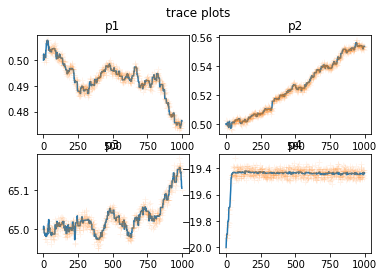

In [265]:
fig,ax = plt.subplots(2,2)
fig.suptitle('trace plots')
rej_a =.08
ax[0,0].plot(chn[:,0])
ax[0,0].plot(rej[:,0], '+', alpha=rej_a)
ax[0,0].set_title('p1')
ax[0,1].plot(chn[:,1])
ax[0,1].plot(rej[:,1], '+', alpha=rej_a)
ax[0,1].set_title('p2')
ax[1,0].plot(chn[:,2])
ax[1,0].plot(rej[:,2], '+', alpha=rej_a)
ax[1,0].set_title('p3')
ax[1,1].plot(chn[:,3])
ax[1,1].plot(rej[:,3], '+', alpha=rej_a)
ax[1,1].set_title('p4')

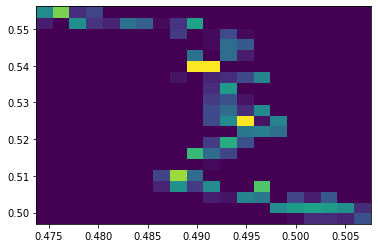

In [266]:
plt.hist2d(chn[:,0],chn[:,1], bins=20, density=1);